In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
with xr.open_dataset('data/MERRA-2/merged.nc4') as ds:
    ds.load()
    
df = ds.to_dataframe()
df.index.set_names(['lat', 'lon', 'Date'], inplace=True)
df.reset_index(inplace=True)

# take only those values that cover Houston
north, south, east, west = (30.5, 29, -94.5, -96)

filt = (df['lat'] > south) & (df['lat'] < north) & (df['lon'] > west) & (df['lon'] < east)
df = df[filt]

# convert PM2.5 to be in units of micrograms / m^3
df['PM2.5'] = df['PM2.5'] * 1e9

In [3]:
df

,lat,lon,Date,SSSMASS25,DUSCATAU,BCSCATAU,DUEXTTAU,BCFLUXU,OCFLUXV,BCANGSTR,...,SLP,TQV,V2M,TROPQ,V10M,U50M,U10M,QV2M,TROPPV,QV10M
94256,29.5,-95.625,2015-01-01,4.533399e-10,0.002021,0.002087,0.002156,0.000004,0.000019,1.512882,...,102502.109375,33.872681,-2.449461,0.000014,-3.480748,-2.715095,-2.106504,0.005170,12385.588867,0.005072
94257,29.5,-95.625,2015-01-02,6.423546e-10,0.001370,0.002210,0.001459,0.000005,0.000035,1.496467,...,101835.914062,35.265064,-1.914652,0.000012,-2.711771,-1.203307,-0.913161,0.006570,11865.560547,0.006467
94258,29.5,-95.625,2015-01-03,5.319692e-10,0.001622,0.003452,0.001729,0.000011,0.000058,1.491463,...,101459.898438,35.948349,-1.075062,0.000006,-1.526446,3.363282,2.576123,0.007270,11325.949219,0.007129
94259,29.5,-95.625,2015-01-04,9.017004e-10,0.004917,0.001290,0.005263,0.000008,0.000015,1.427629,...,102459.328125,8.960220,-2.824340,0.000018,-4.190116,1.659939,1.085879,0.005313,12323.019531,0.005246
94260,29.5,-95.625,2015-01-05,1.128566e-09,0.001995,0.001070,0.002119,0.000004,0.000009,1.458390,...,103588.531250,4.468480,-2.647162,0.000015,-3.835776,-1.352524,-0.990397,0.003287,13011.084961,0.003148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120555,30.0,-95.000,2020-12-27,2.644830e-09,0.004314,0.000919,0.004610,0.000004,-0.000003,1.420772,...,101785.757812,17.180527,1.702342,0.000003,3.421182,-2.415095,-1.175590,0.008967,9196.285156,0.008873
120556,30.0,-95.000,2020-12-28,2.339227e-09,0.003801,0.000975,0.004061,0.000004,0.000005,1.430284,...,102062.609375,21.724472,1.224436,0.000004,2.619898,-2.311006,-1.453111,0.010594,10317.959961,0.010533
120557,30.0,-95.000,2020-12-29,2.954295e-09,0.002281,0.000758,0.002430,0.000004,0.000015,1.418531,...,102127.914062,19.218693,1.293051,0.000003,2.436874,-6.182795,-3.710495,0.009742,9860.671875,0.009654
120558,30.0,-95.000,2020-12-30,5.271861e-09,0.001837,0.000935,0.001960,0.000005,0.000028,1.424324,...,101397.546875,25.310759,1.794293,0.000002,3.386426,-4.566867,-2.814300,0.012001,10461.372070,0.011901


In [4]:
train_filt = df['Date'] < '2019-01-01'
val_filt = (df['Date'] > '2018-12-31') & (df['Date'] < '2020-01-01')
test_filt = df['Date'] > '2019-12-31'

def subset_dataframe(df, filt):
    features_to_keep = {
        'PS': 'Surface pressure',
        'QV2M': '2-meter specific humidity',
        'QV10M': '10-meter specific humidity',
        'T2M': '2-meter air temperature',
        'T10M' : '10-meter air temperature',
        'U2M': '2-meter eastward wind',
        'V2M': '2-meter northward wind',
        'U50M': '50-meter eastward wind',
        'V50M': '50-meter northward wind',
        'U10M': '10-meter eastward wind',
        'V10M': '10-meter northward wind',
        'TQL': 'Total precipitable liquid water',
        'TQI': 'Total precipitable ice water',
        'TQV': 'Total precipitable water vapor',
        'CLDTOT': 'Total cloud area fraction',
        'PM2.5': 'PM2.5',
        'AODANA': 'Aerosol Optical Depth Analysis',
        'AODINC' : 'Aerosol Optical Depth Analysis Increment',
        'TO3' : 'total column ozone',
        'TS' : 'surface skin temperature',
        'Date': 'Date',
        'lat': 'latitude',
        'lon': 'longitude'
    }
    df = df[filt].loc[:, features_to_keep.keys()] \
        .set_index('Date') \
        .sort_index()
    
    df['Month'] = df.index.month
    return df


train = subset_dataframe(df, train_filt)
val = subset_dataframe(df, val_filt)
test = subset_dataframe(df, test_filt)

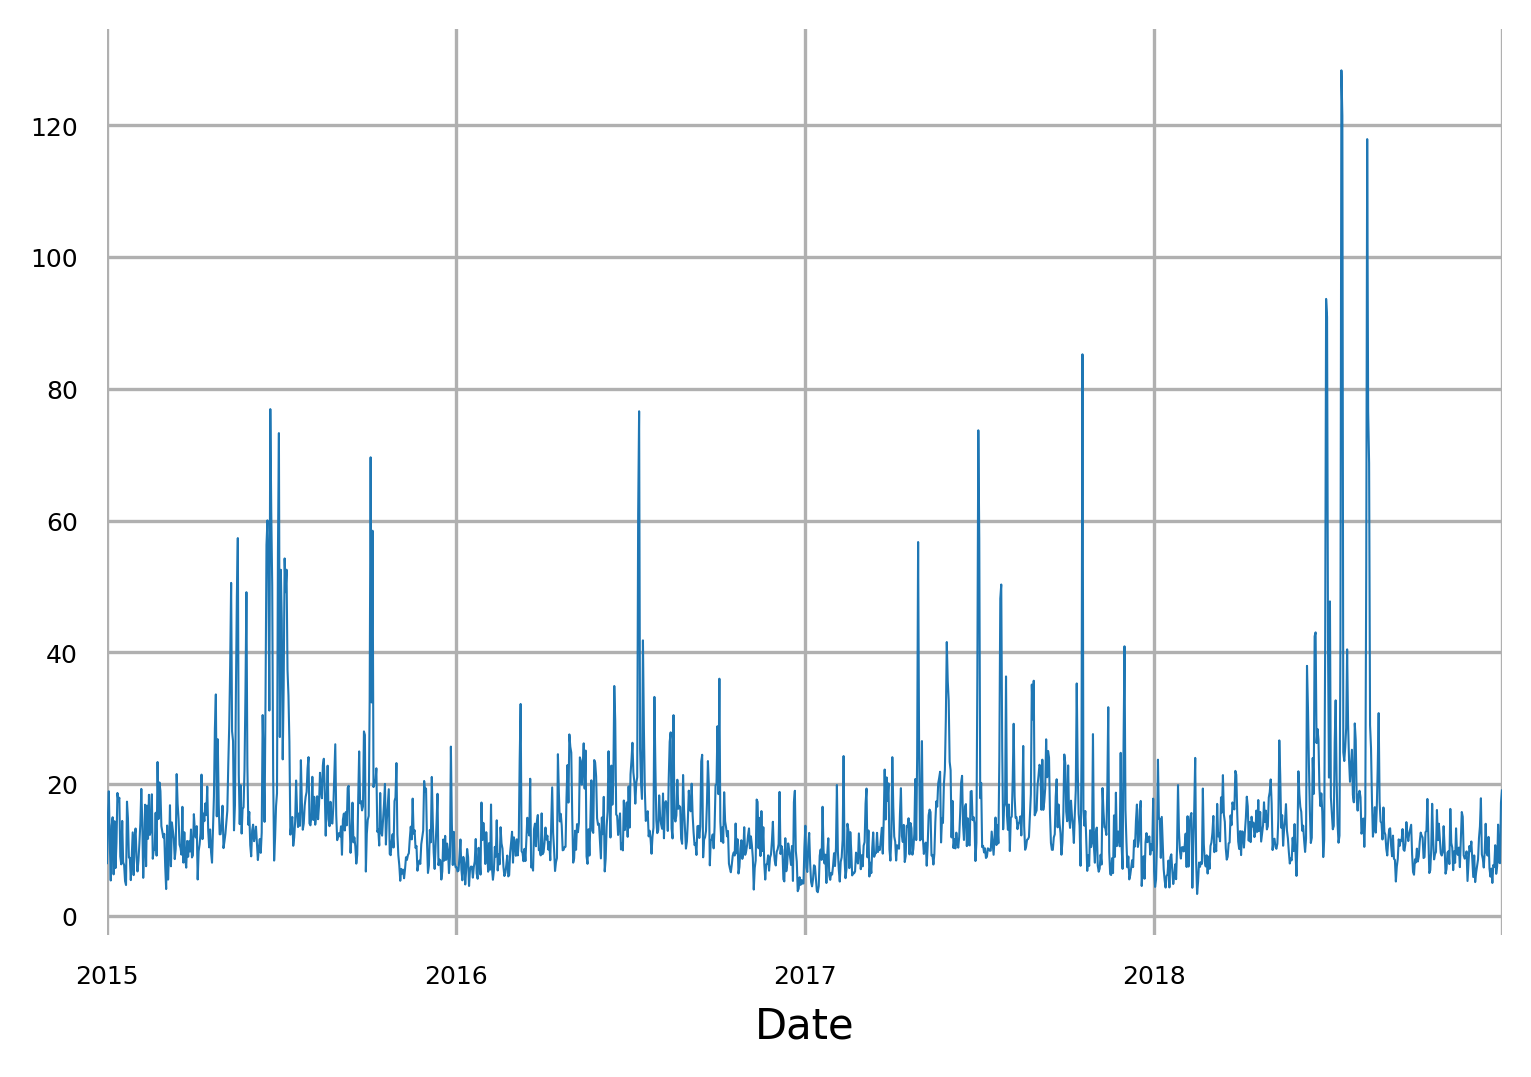

In [119]:
fig, ax = plt.subplots(dpi=300)

train.resample('D').mean().plot(y='PM2.5', ax=ax, lw=0.5, legend=False)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(axis='both', labelsize=6, width=0, which='both')
ax.grid()

In [123]:
from sklearn import preprocessing
import scipy.stats as stats

def histogram_density_plot(df, bins = 30, by = None):
    fig, ax = plt.subplots(dpi=600)

    density = stats.kde.gaussian_kde(df[by].values)
    x = np.linspace(0, df[by].values.max(), 500)
    density = density(x)

    ax.plot(x, density, alpha=0.7, lw=1, color='#9CDEF6')
    ax.fill_between(x, density, alpha=0.4, color='#9CDEF6')

    n, _, patches = ax.hist(df[by], bins=bins, rwidth=0.75, density=True, alpha=0.7, zorder=3, color='#6549DA')
    counts = df[by].value_counts(bins=bins, sort=False)
    for count, bar in zip(counts, patches):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()+.0005, f'{count}', fontsize=6, ha='center')

    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', labelsize=6, width=0, which='both')
    ax.grid(True, alpha=0.2)

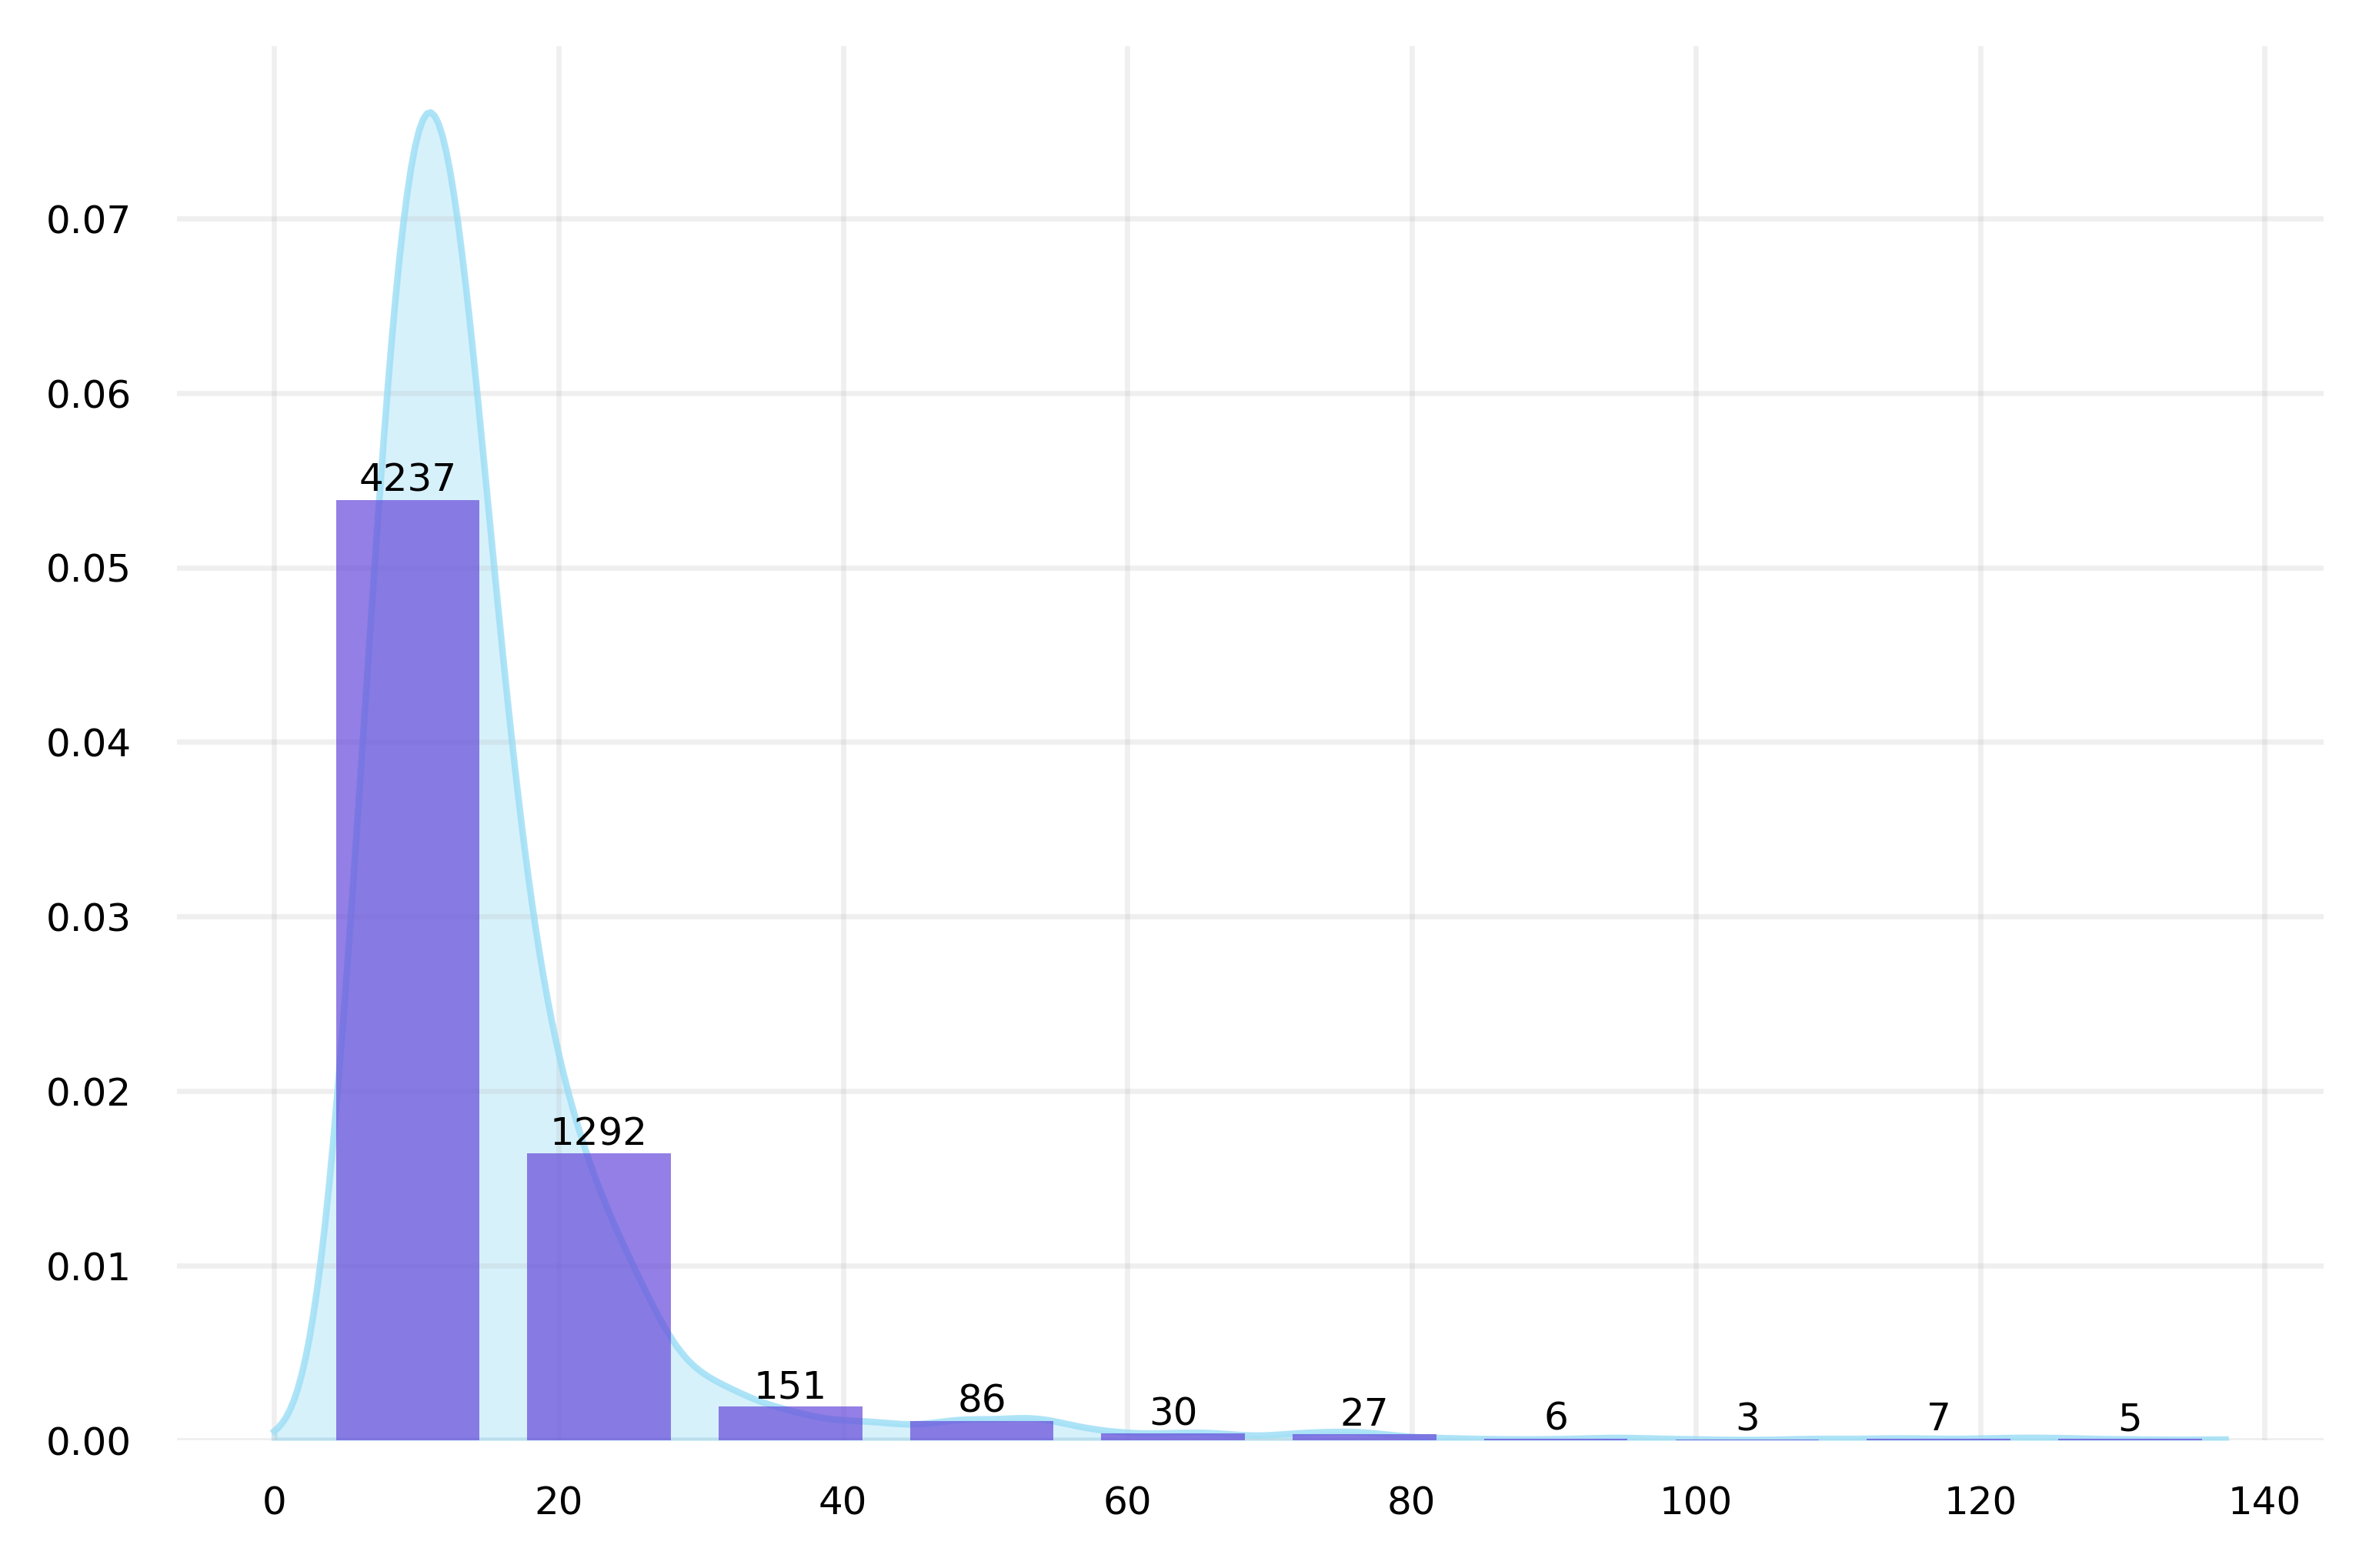

In [124]:
# daily = train.resample('D').mean()
histogram_density_plot(train, by='PM2.5', bins=10)

In [9]:
from sklearn.feature_selection import mutual_info_regression, SelectKBest

X, y = train.drop('PM2.5', axis=1), train['PM2.5']

features = SelectKBest(mutual_info_regression, k=10)
features.fit(X, y)

x = X.loc[:, features.get_support()]
x.head()

,QV2M,QV10M,T2M,T10M,TQI,TQV,AODANA,TO3,TS,Month
Date,,,,,,,,,,
2015-01-01,0.005170,0.005072,279.765778,279.664124,0.027982,33.872681,0.140065,272.728241,280.186188,1
2015-01-01,0.004916,0.004818,278.565674,278.501373,0.038740,32.573849,0.134578,269.303589,278.810760,1
2015-01-01,0.005039,0.004922,279.140472,279.059967,0.031797,32.869099,0.127884,270.364380,279.645569,1
2015-01-01,0.005820,0.005627,281.634613,281.458069,0.024823,34.214149,0.135506,273.467163,283.206757,1
2015-01-02,0.006570,0.006467,282.227631,282.130585,0.043295,35.265064,0.206579,282.313446,282.719147,1


In [37]:
def stratified_kfold(y, k=10):
    # stratified k-fold cross validation: https://stackoverflow.com/a/54946733/5217293
    y_cat = pd.cut(y, k, labels=range(k))
    return StratifiedKFold(k).split(x, y_cat)

def print_scores(scores):
    r2 = scores["test_r2"].mean()
    mae = np.abs(scores["test_neg_mean_absolute_error"]).mean()
    rmse = np.abs(scores["test_neg_root_mean_squared_error"]).mean()
    print('R2, MAE, RMSE')
    print(f'{r2:.2f}, {mae:.2f}, {rmse:.2f}')

In [38]:
scoring=['r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error']

In [39]:
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.pipeline import Pipeline

lm = LinearRegression().fit(x, y)

reg_scores = cross_validate(lm, x, y, 
                            cv=stratified_kfold(y, 10), 
                            scoring=scoring)

print_scores(reg_scores)

R2, MAE, RMSE
0.33, 5.02, 8.90


/Users/kyle/Documents/HoustonPM2.5/houston/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


In [40]:
from sklearn.linear_model import ElasticNetCV

elastic = ElasticNetCV(cv=10, 
                       l1_ratio=np.arange(0.1, 1.1, .1),
                       max_iter=10000
                      )
elastic.fit(x, y)

elastic_scores = cross_validate(elastic, x, y, 
                                cv=stratified_kfold(y, 10), 
                                scoring=scoring)

print_scores(elastic_scores)

/Users/kyle/Documents/HoustonPM2.5/houston/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


R2, MAE, RMSE
0.32, 5.02, 8.98


In [41]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV

polynomial_pipe = Pipeline([('poly', PolynomialFeatures()),
                  ('linear', LinearRegression())]) 

params={'poly__degree': [1, 2, 3]}

poly_grid = GridSearchCV(polynomial_pipe, params, cv=10, scoring=scoring, refit='neg_root_mean_squared_error')

poly_grid.fit(x, y)

polynomial_scores = cross_validate(poly_grid, x, y, 
                                cv=stratified_kfold(y, 10), 
                                scoring=scoring)

print_scores(polynomial_scores)

/Users/kyle/Documents/HoustonPM2.5/houston/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


R2, MAE, RMSE
0.41, 5.12, 8.30


In [127]:
from sklearn.linear_model import BayesianRidge

bayesian_ridge = BayesianRidge().fit(x, y)

bayesian_ridge.fit(x, y)

bayesian_ridge_scores = cross_validate(bayesian_ridge, x, y, 
                            cv=stratified_kfold(y, 10), 
                            scoring=scoring)

print_scores(bayesian_ridge_scores)

R2, MAE, RMSE
0.33, 5.02, 8.91


/Users/kyle/Documents/HoustonPM2.5/houston/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


In [ ]:
from sklearn.svm import SVR

params={'C': np.arange(1, 2, 0.1)}

svr_grid = GridSearchCV(SVR(), params, cv=10, scoring=scoring, refit='neg_root_mean_squared_error')

svr_grid.fit(x, y)

svr_scores = cross_validate(svr_grid, x, y, 
                                cv=stratified_kfold(y, 10), 
                                scoring=scoring)

print_scores(svr_scores)

/Users/kyle/Documents/HoustonPM2.5/houston/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


In [42]:
# poly_grid.best_params_
# poly_grid.best_estimator_.named_steps['poly'].get_feature_names(x.columns)
# poly_grid.best_estimator_.named_steps['linear'].coef_

{'poly__degree': 2}

In [80]:
def score_boxplot(score_type, *args, title='', labels=None):
    if labels is None:
        raise ValueError("Provide labels")
    scores = [np.abs(arg[score_type]) for arg in args]
    
    fig, ax = plt.subplots(dpi=300)
    
    ax.boxplot(scores, labels=labels)
    
    ax.set_title(title)
    
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', labelsize=6, width=0, which='both')
    ax.grid(alpha=0.2)

In [ ]:
scores = [polynomial_scores, elastic_scores, reg_scores, bayesian_ridge_scores]
labels=['Polynomial', 'ElasticNet', 'Linear Regression']

score_boxplot('test_neg_root_mean_squared_error', *scores, title='RMSE', labels=labels)
score_boxplot('test_r2', *scores, title='R2', labels=labels)
score_boxplot('test_neg_mean_absolute_error', *scores, title='MSE', labels=labels)